### Test on ECG Data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

Try to design and train your MLP to classify normal and abnormal ECG samples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(123)
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [2]:
import os
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #有多个GPU时可以指定只使用第几号GPU
config = tf.compat.v1.ConfigProto() 
config.allow_soft_placement=True #允许动态放置张量和操作符
config.gpu_options.per_process_gpu_memory_fraction = 0.4 #最多使用40%GPU内存
config.gpu_options.allow_growth=True   #初始化时不全部占满GPU显存, 按需分配 
sess = tf.compat.v1.Session(config = config)
set_session(sess)

In [3]:
!nvidia-smi

Sun Feb 21 20:58:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    36W /  70W |    222MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setting Gpu

In [4]:
import torch 
from google.colab import drive
#drive.mount('/content/drive')
#dataset_url = "/content/drive/My Drive/Colab Notebooks/Lancaster/apply data mining/"
#program_url = "/content/drive/My Drive/Colab Notebooks/Lancaster/apply data mining/"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

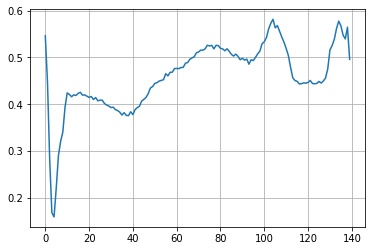

In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(140), train_data[6])
plt.show()

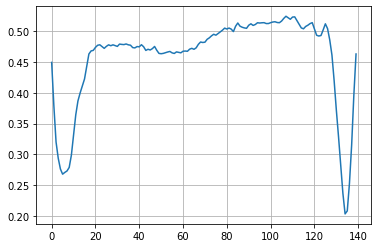

In [6]:
plt.grid()
plt.plot(np.arange(140), train_data[7])
plt.show()

In [7]:
import keras

In [8]:
x_train = train_data
x_test = test_data
y_train = train_labels
y_test = test_labels

In [9]:
#validation dataset
x_val = x_train[:400]
partial_x_train = x_train[400:]
 
y_val = y_train[:400]
partial_y_train = y_train[400:]

In [10]:
from keras import models
from keras import layers
from keras.layers import Activation, Dense, Dropout
import matplotlib.pyplot as plt

In [11]:
if_cuda = torch.cuda.is_available()
if_cuda

True

In [12]:
from keras import backend as K
import tensorflow as tf 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1-D CNN**

In [13]:
x_train_cnn = np.array(x_train)
x_test_cnn = np.array(x_test)
x_val_cnn = np.array(x_val)
partial_x_train_cnn = np.array(partial_x_train)

In [14]:
partial_x_train_cnn.shape

(3598, 140)

In [15]:
#reshape data to fit model
x_train_cnn = x_train_cnn.reshape(3998,140,1)
x_test_cnn = x_test_cnn.reshape(1000,140,1)
x_val_cnn = x_val_cnn.reshape(400,140,1)
partial_x_train_cnn = partial_x_train_cnn.reshape(3598,140,1)


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Conv1D,GlobalMaxPooling1D

#create model
model = Sequential()
#add model layers
model.add(Conv1D(64, kernel_size=20, activation='relu', input_shape=(140,1)))
model.add(GlobalMaxPooling1D())
#model.add(Conv1D(32, kernel_size=4, activation='relu'))
#model.add(GlobalMaxPooling1D())
#model.add(Conv1D(8, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 121, 64)           1344      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
______________________________________________________

In [18]:
#compile model using accuracy to measure model performance
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,tf.keras.metrics.AUC()])

In [19]:
CNN = model.fit(partial_x_train_cnn,
              partial_y_train,
              epochs=40, #模型所有資料看一遍叫做1個epochs
              batch_size=32, #一次512筆資料，才更新權重(原則上越多越好)。32就不錯了
              validation_data=(x_val_cnn,y_val)) #驗證集
    
    
    
#x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/40
113/113 [==============================] - 4s 11ms/step - loss: 0.6665 - acc: 0.5800 - f1_m: 0.7068 - auc: 0.6491 - val_loss: 0.5580 - val_acc: 0.7825 - val_f1_m: 0.8440 - val_auc: 0.9598
Epoch 2/40
113/113 [==============================] - 1s 5ms/step - loss: 0.4638 - acc: 0.8347 - f1_m: 0.8828 - auc: 0.9764 - val_loss: 0.2209 - val_acc: 0.9575 - val_f1_m: 0.9639 - val_auc: 0.9934
Epoch 3/40
113/113 [==============================] - 1s 5ms/step - loss: 0.1717 - acc: 0.9603 - f1_m: 0.9664 - auc: 0.9857 - val_loss: 0.4057 - val_acc: 0.8100 - val_f1_m: 0.8069 - val_auc: 0.9871
Epoch 4/40
113/113 [==============================] - 1s 6ms/step - loss: 0.1174 - acc: 0.9562 - f1_m: 0.9593 - auc: 0.9903 - val_loss: 0.1679 - val_acc: 0.9650 - val_f1_m: 0.9706 - val_auc: 0.9934
Epoch 5/40
113/113 [==============================] - 1s 6ms/step - loss: 0.0835 - acc: 0.9703 - f1_m: 0.9749 - auc: 0.9954 - val_loss: 0.0994 - val_acc: 0.9600 - val_f1_m: 0.9660 - val_auc: 0.9971
Epoch 6/4

In [20]:

loss_and_metrics_cnn = model.evaluate(x_test_cnn, y_test, batch_size=128)
classes_cnn = model.predict(x_test_cnn, batch_size=128)

8/8 [==============================] - 0s 24ms/step - loss: 0.0419 - acc: 0.9870 - f1_m: 0.9884 - auc: 0.9963


In [21]:
cnn_folds_acc = []
cnn_folds_f1 = []
cnn_folds_auc = []
for i in range (10):
  if i ==9:
    x_test_cnn_folds = x_test_cnn[i*100:]
    y_test_folds = y_test[i*100:]
  else:
    x_test_cnn_folds = x_test_cnn[100*i:100*(i+1)]
    y_test_folds = y_test[100*i:100*(i+1)]
  print("testing fold", i+1, "result")
  test_fold_result = model.evaluate(x_test_cnn_folds, y_test_folds, batch_size=128)
  cnn_folds_acc.append(test_fold_result[1])
  cnn_folds_f1.append(test_fold_result[2])
  cnn_folds_auc.append(test_fold_result[3])
print(sum(cnn_folds_acc)/len(cnn_folds_acc))
print(sum(cnn_folds_f1)/len(cnn_folds_f1))
print(sum(cnn_folds_auc)/len(cnn_folds_auc))

testing fold 1 result
1/1 [==============================] - 0s 111ms/step - loss: 0.0762 - acc: 0.9800 - f1_m: 0.9833 - auc: 0.9841
testing fold 2 result
1/1 [==============================] - 0s 16ms/step - loss: 0.0710 - acc: 0.9600 - f1_m: 0.9649 - auc: 0.9988
testing fold 3 result
1/1 [==============================] - 0s 21ms/step - loss: 0.0059 - acc: 1.0000 - f1_m: 1.0000 - auc: 1.0000
testing fold 4 result
1/1 [==============================] - 0s 15ms/step - loss: 0.0141 - acc: 1.0000 - f1_m: 1.0000 - auc: 1.0000
testing fold 5 result
1/1 [==============================] - 0s 15ms/step - loss: 0.0733 - acc: 0.9800 - f1_m: 0.9808 - auc: 0.9962
testing fold 6 result
1/1 [==============================] - 0s 17ms/step - loss: 0.0257 - acc: 0.9800 - f1_m: 0.9825 - auc: 0.9996
testing fold 7 result
1/1 [==============================] - 0s 17ms/step - loss: 0.0696 - acc: 0.9900 - f1_m: 0.9916 - auc: 0.9837
testing fold 8 result
1/1 [==============================] - 0s 18ms/step -

In [22]:
history_dict_CNN = CNN.history
history_dict_CNN.keys()

dict_keys(['loss', 'acc', 'f1_m', 'auc', 'val_loss', 'val_acc', 'val_f1_m', 'val_auc'])

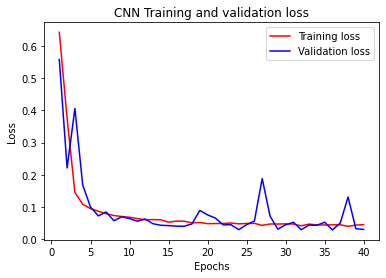

In [23]:
import matplotlib.pyplot as plt
 
acc = CNN.history['acc']
val_acc = CNN.history['val_acc']
loss = CNN.history['loss']
val_loss = CNN.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

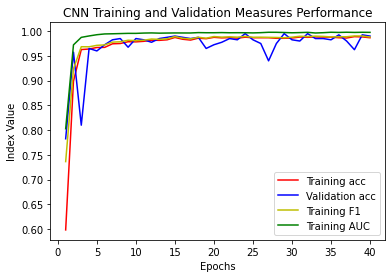

In [24]:
plt.clf()   # clear figure
acc_values = history_dict_CNN['acc']
val_acc_values = history_dict_CNN['val_acc']
f1_values = history_dict_CNN['f1_m']
auc_values = history_dict_CNN['auc']
 
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.plot(epochs, f1_values, 'y', label='Training F1')
plt.plot(epochs, auc_values, 'g', label='Training AUC')

plt.title('CNN Training and Validation Measures Performance')
plt.xlabel('Epochs')
plt.ylabel('Index Value')
plt.legend()

plt.show()

# **LSTM**

In [25]:
x_train_lstm = np.array(x_train)
x_test_lstm = np.array(x_test)
x_val_lstm = np.array(x_val)
partial_x_train_lstm = np.array(partial_x_train)

In [26]:
#reshape data to fit model
x_train_lstm = x_train_lstm.reshape(3998,10,14)
x_test_lstm = x_test_lstm.reshape(1000,10,14)
x_val_lstm = x_val_lstm.reshape(400,10,14)
partial_x_train_lstm = partial_x_train_lstm.reshape(3598,10,14)

In [27]:
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(10,14)))
#model.add(Dropout(0.5)))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,tf.keras.metrics.AUC()])

In [29]:
lstm = model.fit(partial_x_train_lstm,
              partial_y_train,
              epochs=40, #模型所有資料看一遍叫做1個epochs
              batch_size=32, #一次512筆資料，才更新權重(原則上越多越好)。32就不錯了
              validation_data=(x_val_lstm,y_val)) #驗證集

Epoch 1/40
113/113 [==============================] - 3s 11ms/step - loss: 0.6578 - acc: 0.5834 - f1_m: 0.6384 - auc_1: 0.6084 - val_loss: 0.5139 - val_acc: 0.7925 - val_f1_m: 0.7961 - val_auc_1: 0.9336
Epoch 2/40
113/113 [==============================] - 1s 7ms/step - loss: 0.3021 - acc: 0.9098 - f1_m: 0.9275 - auc_1: 0.9514 - val_loss: 0.0916 - val_acc: 0.9650 - val_f1_m: 0.9700 - val_auc_1: 0.9939
Epoch 3/40
113/113 [==============================] - 1s 6ms/step - loss: 0.0996 - acc: 0.9733 - f1_m: 0.9768 - auc_1: 0.9875 - val_loss: 0.0732 - val_acc: 0.9775 - val_f1_m: 0.9811 - val_auc_1: 0.9966
Epoch 4/40
113/113 [==============================] - 1s 6ms/step - loss: 0.0855 - acc: 0.9757 - f1_m: 0.9791 - auc_1: 0.9917 - val_loss: 0.0625 - val_acc: 0.9825 - val_f1_m: 0.9846 - val_auc_1: 0.9969
Epoch 5/40
113/113 [==============================] - 1s 6ms/step - loss: 0.0699 - acc: 0.9831 - f1_m: 0.9853 - auc_1: 0.9904 - val_loss: 0.0842 - val_acc: 0.9725 - val_f1_m: 0.9768 - val_auc

In [30]:
loss_and_metrics_lstm = model.evaluate(x_test_lstm, y_test, batch_size=128)
classes_lstm = model.predict(x_test_lstm, batch_size=128)

8/8 [==============================] - 0s 3ms/step - loss: 0.0363 - acc: 0.9900 - f1_m: 0.9906 - auc_1: 0.9988


In [31]:
lstm_folds_acc = []
lstm_folds_f1 = []
lstm_folds_auc = []
for i in range (10):
  if i ==9:
    x_test_lstm_folds = x_test_lstm[i*100:]
    y_test_folds = y_test[i*100:]
  else:
    x_test_lstm_folds = x_test_lstm[100*i:100*(i+1)]
    y_test_folds = y_test[100*i:100*(i+1)]
  print("testing fold", i+1, "result")
  test_fold_result = model.evaluate(x_test_lstm_folds, y_test_folds, batch_size=128)
  lstm_folds_acc.append(test_fold_result[1])
  lstm_folds_f1.append(test_fold_result[2])
  lstm_folds_auc.append(test_fold_result[3])
print(sum(lstm_folds_acc)/len(lstm_folds_acc))
print(sum(lstm_folds_f1)/len(lstm_folds_f1))
print(sum(lstm_folds_auc)/len(lstm_folds_auc))

testing fold 1 result
1/1 [==============================] - 0s 16ms/step - loss: 0.0520 - acc: 0.9800 - f1_m: 0.9831 - auc_1: 0.9996
testing fold 2 result
1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - acc: 0.9900 - f1_m: 0.9913 - auc_1: 1.0000
testing fold 3 result
1/1 [==============================] - 0s 18ms/step - loss: 0.0154 - acc: 1.0000 - f1_m: 1.0000 - auc_1: 1.0000
testing fold 4 result
1/1 [==============================] - 0s 17ms/step - loss: 0.0143 - acc: 1.0000 - f1_m: 1.0000 - auc_1: 1.0000
testing fold 5 result
1/1 [==============================] - 0s 17ms/step - loss: 0.0798 - acc: 0.9800 - f1_m: 0.9808 - auc_1: 0.9956
testing fold 6 result
1/1 [==============================] - 0s 16ms/step - loss: 0.0255 - acc: 0.9900 - f1_m: 0.9912 - auc_1: 1.0000
testing fold 7 result
1/1 [==============================] - 0s 19ms/step - loss: 0.0526 - acc: 0.9900 - f1_m: 0.9916 - auc_1: 0.9940
testing fold 8 result
1/1 [==============================] - 0

In [32]:
history_dict_lstm = lstm.history
history_dict_lstm.keys()

dict_keys(['loss', 'acc', 'f1_m', 'auc_1', 'val_loss', 'val_acc', 'val_f1_m', 'val_auc_1'])

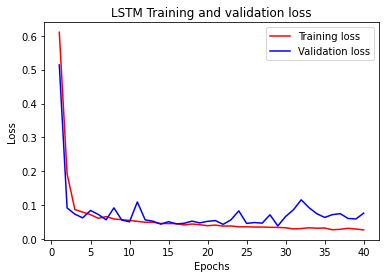

In [33]:
acc = lstm.history['acc']
val_acc = lstm.history['val_acc']
loss = lstm.history['loss']
val_loss = lstm.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()

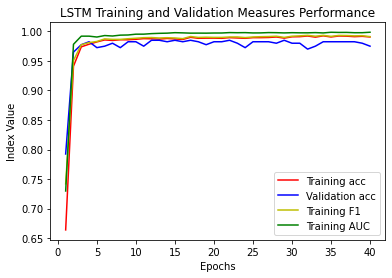

In [34]:
plt.clf()   # clear figure
acc_values = history_dict_lstm['acc']
val_acc_values = history_dict_lstm['val_acc']
f1_values = history_dict_lstm['f1_m']
auc_values = history_dict_lstm['auc_1']
 
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.plot(epochs, f1_values, 'y', label='Training F1')
plt.plot(epochs, auc_values, 'g', label='Training AUC')

plt.title('LSTM Training and Validation Measures Performance')
plt.xlabel('Epochs')
plt.ylabel('Index Value')
plt.legend()

plt.show()

In [35]:
from scipy.stats import ranksums, ttest_ind

print("Non-parametric test")
sta_test = ranksums(lstm_folds_acc,cnn_folds_acc)
print("compare on accuracy",sta_test)

sta_test = ranksums(lstm_folds_f1,cnn_folds_f1)
print("compare on f1-score",sta_test)

sta_test = ranksums(lstm_folds_auc,cnn_folds_auc)
print("compare on AUC",sta_test)

print(" \n\n\nPparametric test")
sta_test = ttest_ind(lstm_folds_acc,cnn_folds_acc)
print("compare on accuracy",sta_test)

sta_test = ttest_ind(lstm_folds_f1,cnn_folds_f1)
print("compare on f1-score",sta_test)

sta_test = ttest_ind(lstm_folds_auc,cnn_folds_auc)
print("compare on AUC",sta_test)

Non-parametric test
compare on accuracy RanksumsResult(statistic=0.37796447300922725, pvalue=0.7054569861112734)
compare on f1-score RanksumsResult(statistic=0.41576092031014994, pvalue=0.6775849579524755)
compare on AUC RanksumsResult(statistic=0.8315218406202999, pvalue=0.40567889528505297)
 


Pparametric test
compare on accuracy Ttest_indResult(statistic=0.6689654659390151, pvalue=0.512006856181082)
compare on f1-score Ttest_indResult(statistic=0.6465662406343801, pvalue=0.5260719661605877)
compare on AUC Ttest_indResult(statistic=1.2632019538619461, pvalue=0.22263445344978294)
